# Plotting global mean distributions

Import modules

In [1]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt

In [2]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Select output variables

In [3]:
var = ["GPP", "LHF"]
nvar = len(var)

In [4]:
f=nc.netcdf_file("outputdata/outputdata_"+var[0]+"_GM_100.nc",'r', mmap=False)

In [5]:
X = f.variables[var[0]]
outputdata = X[:]

In [6]:
f_obs = 937.298 # from obs/process_obs_GM.ncl

In [9]:
f_default = 1030.75 # from outputdata/process_model_GM.ncl

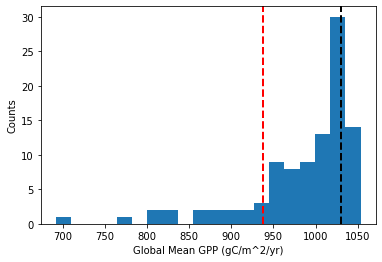

In [11]:
plt.hist(outputdata, bins=20)
plt.axvline(x=f_obs, color='r', linestyle='dashed', linewidth=2)
plt.axvline(x=f_default, color='k', linestyle='dashed', linewidth=2)
plt.xlabel("Global Mean GPP (gC/m^2/yr)")
plt.ylabel('Counts');
#plt.savefig("dist_outputdata_GPP_GM_withobs_anddefault.pdf")

# Plotting EOF distributions with multiple obs products

Note that eof dists and model default calculations are based on FLUXNET datamask (varies slightly when using WECANN datamask)

In [4]:
PPE_modes = [np.load("outputdata/outputdata_"+v+"_SVD_3modes.npy") for v in var]
nmodes = PPE_modes[0].shape[1]
PPE_modes_mean = np.mean(PPE_modes, axis=1)

In [5]:
PPE_modes[0].shape

(100, 3)

In [6]:
Fobs = [np.load("obs/obs_"+v+"_SVD_3modes.npy") for v in var]

In [44]:
Fobs[0].shape
Fobs[0]

array([[ 0.02905951, -0.2637101 , -0.6221654 ]], dtype=float32)

In [8]:
Wobs = [np.load("obs/WECANN_"+v+"_SVD_3modes.npy") for v in var]

In [9]:
Wobs[0].shape

(1, 3)

In [10]:
default_modes = [np.load("outputdata/modeldefault_"+v+"_SVD_3modes.npy") for v in var]

In [11]:
default_modes[1]

array([[ 0.03691884, -0.17049496,  0.09658578]], dtype=float32)

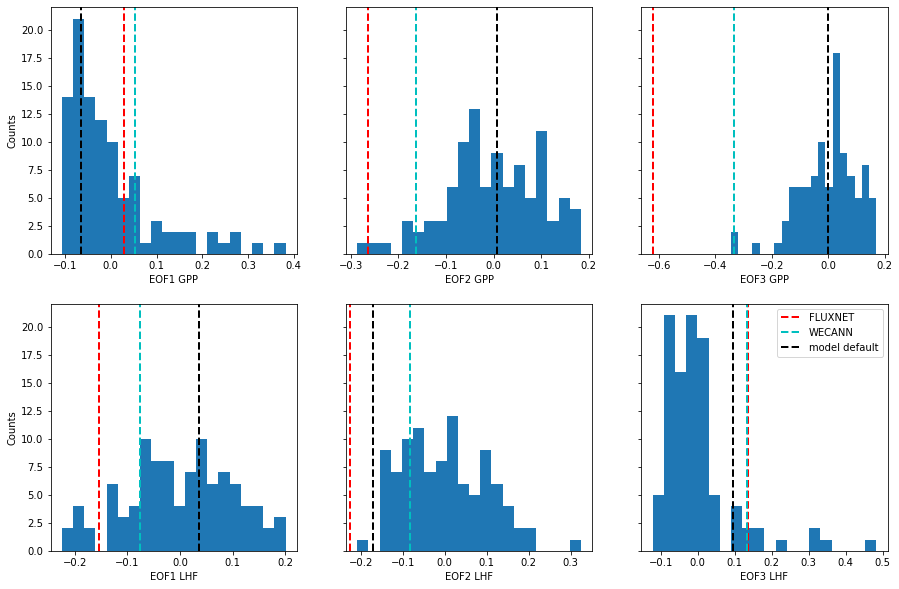

In [16]:
fig, axs = plt.subplots(nvar,nmodes, figsize=(15, 10), sharey=True)
axs = axs.ravel()
for j in range(nvar):
    for i in range(nmodes):
        # indexing is a little hacky
        axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=20)
        axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
        axs[i+nmodes*j].axvline(x=Fobs[j][:,i], color='r', linestyle='dashed', linewidth=2, label="FLUXNET")
        axs[i+nmodes*j].axvline(x=Wobs[j][:,i], color='c', linestyle='dashed', linewidth=2, label="WECANN")
        axs[i+nmodes*j].axvline(x=default_modes[j][:,i], color='k', linestyle='dashed', linewidth=2, label="model default")
        #axs[i+nmodes*j].axvline(x=PPE_modes_mean[j,i], color='g', linestyle='dashed', linewidth=2, label="PPE mean")
        if i == 0:
            axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();
#plt.savefig("dist_outputdata_GPP_LHF_SVD_compareobs_anddefault.pdf")

Compare emulator predictions

In [17]:
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

In [18]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

In [19]:
NN_models = [load_model("emulators/NN_"+v+"_finalize_multi-dim.h5", 
    custom_objects={'mean_sq_err' :mean_sq_err}) for v in var]

W1203 13:29:40.381711 139681355040512 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1203 13:29:40.438340 139681355040512 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1203 13:29:40.538616 139681355040512 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1203 13:29:40.539688 139681355040512 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto 

In [20]:
inputdata = np.load(file="lhc_100.npy", allow_pickle=True)

In [21]:
PPE_preds = [NN_models[i].predict(inputdata) for i,v in enumerate(var)]

In [22]:
print(PPE_preds[0].shape, PPE_preds[1].shape)

(100, 3) (100, 3)


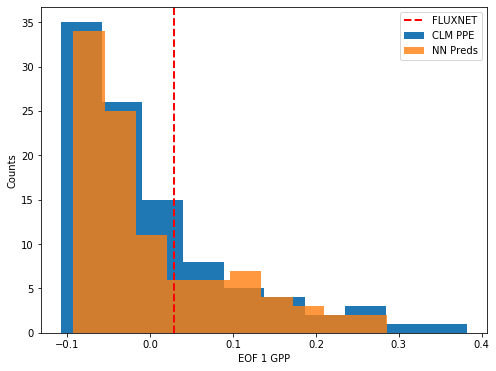

In [23]:
plt.figure(figsize=(8,6))
plt.hist(PPE_modes[0][:,0], bins=10, label="CLM PPE")
plt.hist(PPE_preds[0][:,0], bins=10, alpha=0.8, label="NN Preds")
plt.axvline(x=Fobs[0][:,0], color='r', linestyle='dashed', linewidth=2, label="FLUXNET")
plt.ylabel("Counts")
plt.xlabel("EOF 1 GPP")
plt.legend();
#plt.savefig("dist_outputdata_NNpreds_withobs_GPP_mode1.pdf")

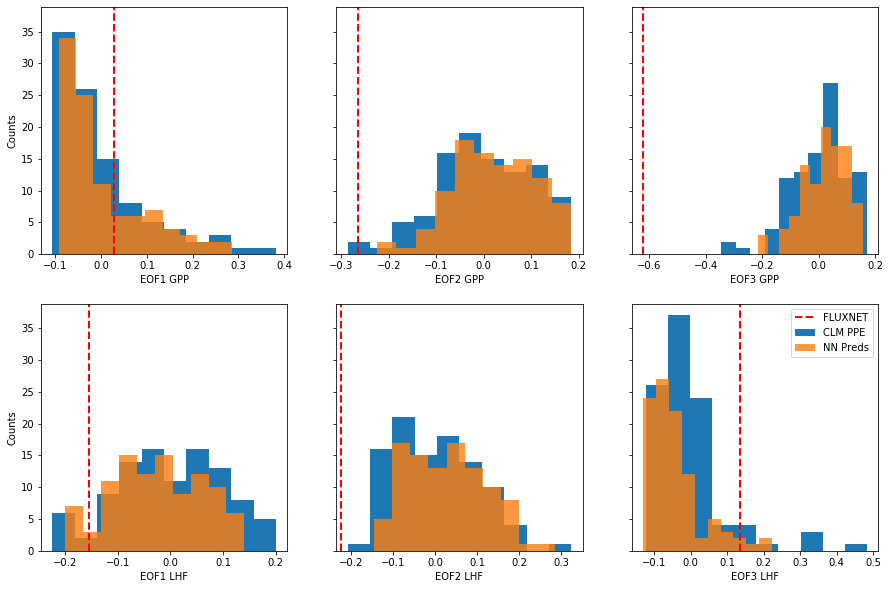

In [24]:
fig, axs = plt.subplots(nvar,nmodes, figsize=(15, 10), sharey=True)
axs = axs.ravel()
for j in range(nvar):
    for i in range(nmodes):
        # indexing is a little hacky
        axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=10, label="CLM PPE")
        axs[i+nmodes*j].hist(PPE_preds[j][:,i], bins=10, alpha=0.8, label="NN Preds")
        axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
        axs[i+nmodes*j].axvline(x=Fobs[j][:,i], color='r', linestyle='dashed', linewidth=2, label="FLUXNET")
        if i == 0:
            axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();
#plt.savefig("dist_outputdata_NNpreds_withobs_GPP_LHF_allmodes.pdf")

In [25]:
obs_sd = [np.load("obs/obs_"+v+"_SVD_3modes_allyrs_sd.npy") for v in var]

In [26]:
obs_sd

[array([0.00325403, 0.01975097, 0.02706034], dtype=float32),
 array([0.00742627, 0.01579977, 0.02434924], dtype=float32)]

Set % variance explained (for weighted loss function)

In [27]:
# variance recorded in NN develop and test spreadsheet, taken from SVD.ipynb
var_modes = [[0.83406484, 0.1348919, 0.01192334],[0.7701996, 0.12915632, 0.05642754]]
#var_modes[0]

Calculate normalized error using PPE results (i.e, what is the optimization baseline goal?)

In [28]:
PPE_err_terms = [np.sum(var_modes[i]*((PPE_modes[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
PPE_err = np.sum(PPE_err_terms, axis=0)
PPE_opt = np.argmin(PPE_err)
print(PPE_opt) # ensemble member
print(PPE_err[PPE_opt]) # minimum value for PPE_err
print(inputdata[PPE_opt,:]) # parameter scalers for optimal PPE run
#plt.plot(PPE_err);
#plt.hist(PPE_err);

91
78.18192243245684
[0.012258808437009697 0.005129054111486312 0.8935897464922476
 0.008913871243116942 0.5658423417289229 0.01916343947088633]


In [29]:
print(PPE_modes[0][PPE_opt]) # Simulated GPP EOFs
print(PPE_modes[1][PPE_opt]) # Simulated LHF EOFs

[ 0.00419694 -0.06063284 -0.16822883]
[-0.13587941 -0.13891841  0.32639188]


Looks like GPP might still be dominating the optimization due to smaller natural variability and/or greater distance from targets

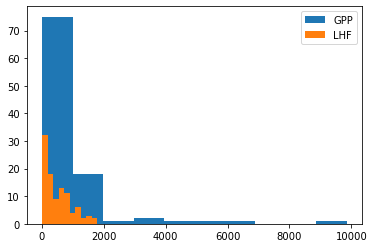

In [30]:
plt.hist(PPE_err_terms[0], label="GPP")
plt.hist(PPE_err_terms[1], label="LHF")
plt.legend();

In [31]:
print(PPE_err_terms[0][PPE_opt]) # GPP error term for optimal PPE run
print(PPE_err_terms[1][PPE_opt]) # LHF error term

66.30656567045318
11.875356762003669


## Single point optimization

More modules

In [46]:
from scipy.optimize import shgo, dual_annealing, differential_evolution

Define likelihood function using emulator predictions

In [47]:
def normerr(x):
    xt = x.reshape(1,-1) # needed for input to model.predict
    NN_preds = [NN_models[i].predict(xt) for i,v in enumerate(var)]
    #terms = [np.sum(((NN_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
    terms = [np.sum(var_modes[i]*((NN_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # mode wgt
    # Weighted multiple objectives
    #L = terms[0] + B*terms[1]
    # Unweighted multiple objectives
    L = np.sum(terms)
    return L

SHGO global optimization

In [31]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
res = shgo(normerr, bounds)
print(res)
# Do the initial conditions for SHGO matter? Is it getting stuck? Not iterating very much...

     fun: 162.32543381643436
    funl: array([162.32543382])
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 2
   nlfev: 8
   nlhev: 0
   nljev: 1
 success: True
       x: array([0., 1., 1., 1., 1., 1.])
      xl: array([[0., 1., 1., 1., 1., 1.]])


Modified SHGO options

In [35]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
res = shgo(normerr, bounds, iters=3, sampling_method='sobol') # result generally does not change when iters goes from 1-5
print(res)

     fun: 87.29109488727525
    funl: array([87.29109489, 93.25418874])
 message: 'Optimization terminated successfully.'
    nfev: 334
     nit: 3
   nlfev: 34
   nlhev: 0
   nljev: 3
 success: True
       x: array([0.16796875, 0.48828125, 0.25390625, 0.16015625, 0.68359375,
       0.01171875])
      xl: array([[0.16796875, 0.48828125, 0.25390625, 0.16015625, 0.68359375,
        0.01171875],
       [0.0783192 , 0.234375  , 0.265625  , 0.984375  , 0.984375  ,
        0.984375  ]])


Dual Annealing global optimization

In [37]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
from pyDOE import *
lhd = lhs(npar,samples=1) # default sampling criterion = random
x0 = lhd[0,:]
#print(x0)
#res = dual_annealing(normerr, bounds=bounds, x0=x0)
res = dual_annealing(normerr, bounds, maxiter=10000, x0=x0)
print(res)

     fun: 26.765855158052993
 message: ['Maximum number of iteration reached']
    nfev: 294834
    nhev: 0
     nit: 10000
    njev: 0
  status: 0
 success: True
       x: array([5.35915926e-01, 1.00000000e+00, 3.08563676e-01, 1.33476282e-08,
       9.99963348e-01, 0.00000000e+00])


Differential Evolution global optimization -- generally this method is best at finding minimum error

In [48]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
#res = differential_evolution(normerr, bounds, init='latinhypercube', disp=True) # with display progress
#res = differential_evolution(normerr, bounds, init='latinhypercube')
res = differential_evolution(normerr, bounds, init='random')
print(res)

     fun: 26.82137482013595
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 6868
     nit: 75
 success: True
       x: array([5.35597482e-01, 9.98161080e-01, 3.08624804e-01, 1.83630571e-05,
       9.99276379e-01, 1.30234840e-03])


In [49]:
res.x

array([5.35597482e-01, 9.98161080e-01, 3.08624804e-01, 1.83630571e-05,
       9.99276379e-01, 1.30234840e-03])

Given single point results, what are the optimized predictions and terms of the normalized error?

In [50]:
opt_preds = [NN_models[i].predict(res.x.reshape(1,-1)) for i,v in enumerate(var)]
opt_preds

[array([[ 0.02961004, -0.04411965, -0.04777409]], dtype=float32),
 array([[-0.14493476, -0.14337583,  0.0908476 ]], dtype=float32)]

Does one term (GPP or LHF) dominate the total error?

In [51]:
terms_preds = [np.sum(var_modes[i]*((opt_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
terms_preds

[array([22.06986391]), array([4.75151091])]

In [32]:
# Manually save optimized predictions from last time (might not be exactly the same repeating optimization)
opt_preds_preserved = [[ 0.03000795, -0.04406739, -0.04776282], [-0.14517023, -0.14306705,  0.090743  ]]
opt_preds_preserved

[[0.03000795, -0.04406739, -0.04776282], [-0.14517023, -0.14306705, 0.090743]]

In [33]:
# Manually save parameter scalers from optimization results
opt_params_preserved = [5.35314627e-01, 9.98124407e-01, 3.08100513e-01, 1.05168812e-04,
       9.98661100e-01, 2.25861839e-04]
opt_params_preserved

[0.535314627,
 0.998124407,
 0.308100513,
 0.000105168812,
 0.9986611,
 0.000225861839]

## Plot distribution with optimized predictions

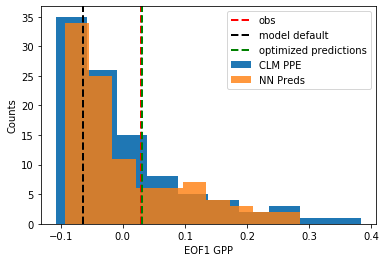

In [34]:
plt.hist(PPE_modes[0][:,0], bins=10, label="CLM PPE")
plt.hist(PPE_preds[0][:,0], bins=10, alpha=0.8, label="NN Preds")
plt.xlabel("EOF"+str(0+1)+" "+var[0])
plt.axvline(x=Fobs[0][:,0], color='r', linestyle='dashed', linewidth=2, label="obs")
plt.axvline(x=default_modes[0][:,0], color='k', linestyle='dashed', linewidth=2, label="model default")
plt.axvline(x=opt_preds_preserved[0][0], color='g', linestyle='dashed', linewidth=2, label="optimized predictions")
plt.ylabel("Counts")
plt.legend();
#plt.savefig("dist_outputdata_NNpreds_GPP_mode1_SVD_withobs_anddefault_andoptpreds_modewgt.pdf")

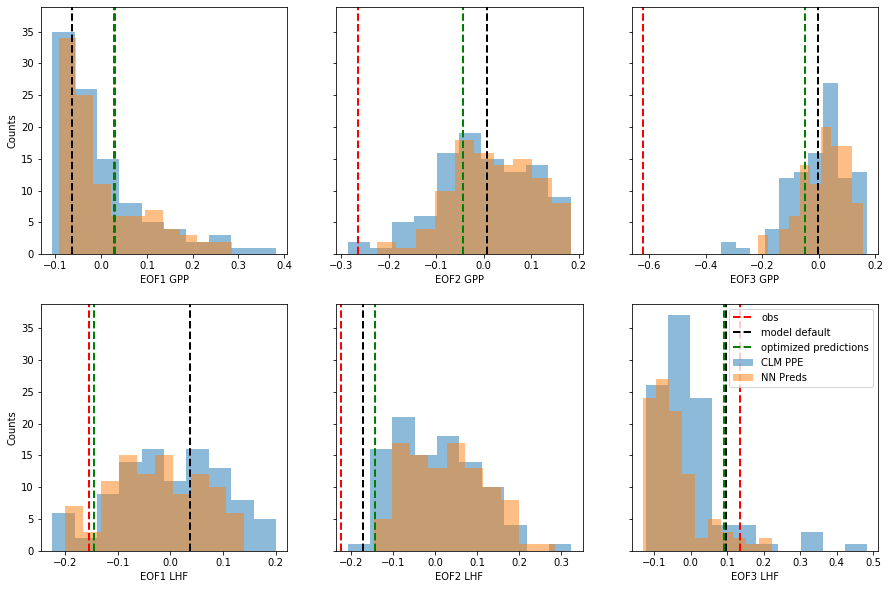

In [38]:
fig, axs = plt.subplots(nvar,nmodes, figsize=(15, 10), sharey=True)
axs = axs.ravel()
for j in range(nvar):
    for i in range(nmodes):
        #axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=10, label="CLM PPE")
        axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=10, color='C0', alpha=0.5, label="CLM PPE")
        #axs[i+nmodes*j].hist(PPE_preds[j][:,i], bins=10, alpha=0.8, label="NN Preds")
        axs[i+nmodes*j].hist(PPE_preds[j][:,i], bins=10, color='C1', alpha=0.5, label="NN Preds")
        axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
        axs[i+nmodes*j].axvline(x=Fobs[j][:,i], color='r', linestyle='dashed', linewidth=2, label="obs")
        axs[i+nmodes*j].axvline(x=default_modes[j][:,i], color='k', linestyle='dashed', linewidth=2, label="model default")
        axs[i+nmodes*j].axvline(x=opt_preds_preserved[j][i], color='g', linestyle='dashed', linewidth=2, label="optimized predictions")
        if i == 0:
            axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();
#plt.savefig("dist_outputdata_NNpreds_GPP_LHF_SVD_withobs_anddefault_andoptpreds_modewgt_altcolors.pdf")

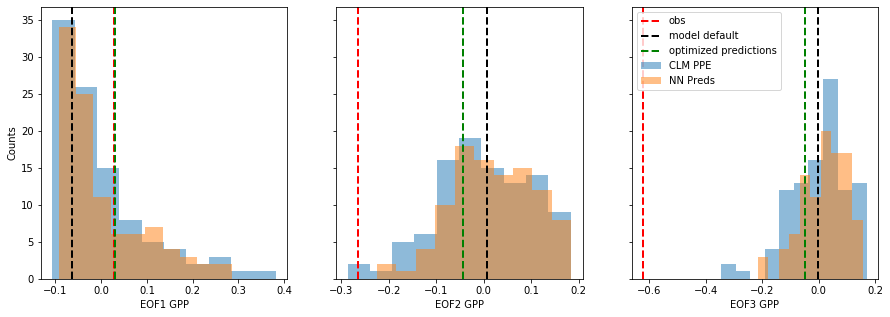

In [43]:
# Plot GPP only
fig, axs = plt.subplots(1,nmodes, figsize=(15, 5), sharey=True)
axs = axs.ravel()
j=0
for i in range(nmodes):
    #axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=10, label="CLM PPE")
    axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=10, color='C0', alpha=0.5, label="CLM PPE")
    #axs[i+nmodes*j].hist(PPE_preds[j][:,i], bins=10, alpha=0.8, label="NN Preds")
    axs[i+nmodes*j].hist(PPE_preds[j][:,i], bins=10, color='C1', alpha=0.5, label="NN Preds")
    axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
    axs[i+nmodes*j].axvline(x=Fobs[j][:,i], color='r', linestyle='dashed', linewidth=2, label="obs")
    axs[i+nmodes*j].axvline(x=default_modes[j][:,i], color='k', linestyle='dashed', linewidth=2, label="model default")
    axs[i+nmodes*j].axvline(x=opt_preds_preserved[j][i], color='g', linestyle='dashed', linewidth=2, label="optimized predictions")
    if i == 0:
        axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();

## Include results of CLM test case (run with optimized parameter values)

In [57]:
# test case results recorded in Sensitivity spreadsheet, taken from SVD.py
test_modes = [[0.03052036, -0.3424246, -0.30153644], [-0.11895278, -0.25456372, 0.4816724]] # test_paramset_SVD_v4

In [60]:
test_modes[0][0]

0.03052036

In [58]:
test_err_terms = [np.sum(var_modes[i]*((test_modes[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
test_err = np.sum(test_err_terms, axis=0)
print(test_err) # simulated L value for test case

[33.08338363]


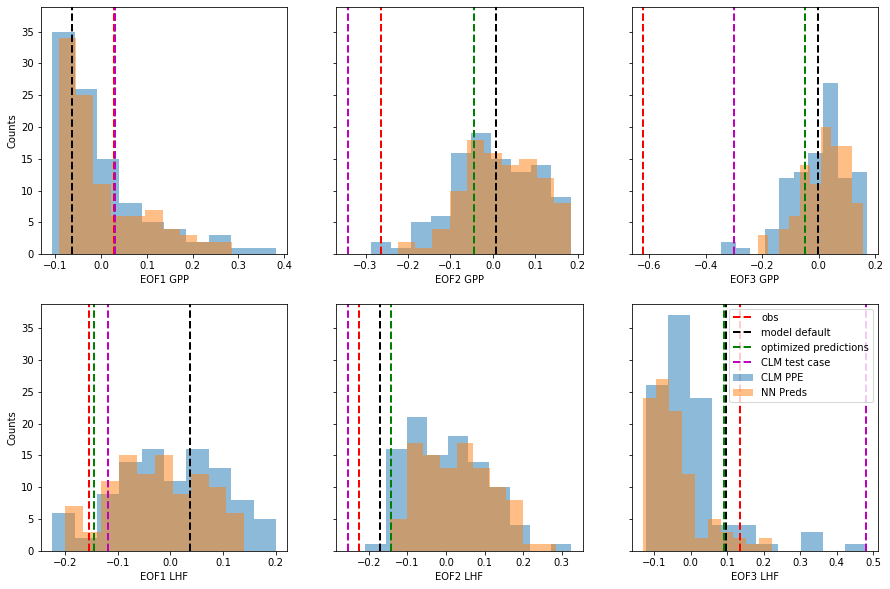

In [94]:
fig, axs = plt.subplots(nvar,nmodes, figsize=(15, 10), sharey=True)
axs = axs.ravel()
for j in range(nvar):
    for i in range(nmodes):
        axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=10, color='C0', alpha=0.5, label="CLM PPE")
        axs[i+nmodes*j].hist(PPE_preds[j][:,i], bins=10, color='C1', alpha=0.5, label="NN Preds")
        axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
        axs[i+nmodes*j].axvline(x=Fobs[j][:,i], color='r', linestyle='dashed', linewidth=2, label="obs")
        axs[i+nmodes*j].axvline(x=default_modes[j][:,i], color='k', linestyle='dashed', linewidth=2, label="model default")
        axs[i+nmodes*j].axvline(x=opt_preds_preserved[j][i], color='g', linestyle='dashed', linewidth=2, label="optimized predictions")
        axs[i+nmodes*j].axvline(x=test_modes[j][i], color='m', linestyle='dashed', linewidth=2, label="CLM test case")
        if i == 0:
            axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();
#plt.savefig("dist_outputdata_NNpreds_GPP_LHF_SVD_withobs_anddefault_andoptpreds_andtest_modewgt.pdf")

## MCMC

In [49]:
import emcee

Cost function for MCMC

In [50]:
def normerr_MCMC(x):
    xt = x.reshape(1,-1)
    NN_preds = [NN_models[i].predict(xt) for i,v in enumerate(var)]
    terms = [np.sum(var_modes[i]*((NN_preds[i]-Fobs[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
    L = -(np.sum(terms)) # unweighted sum (as in, no scaling factor for LHF)
    return L

Define the prior

In [51]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    #if all(x > 0) and all(x < 1):
    if np.all(x > 0) and np.all(x < 1):
        return 0.0
    return -np.inf

Define full log prob function

In [52]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr_MCMC(x)

Number of walkers, number of dimensions = number of parameters

In [53]:
# Note that number of walkers is correlated with runtime
nwalkers = 100
ndim = npar

Initialize walkers (random initial states)\
Could be important to try different initial states here

In [86]:
#p0 = [np.random.rand(ndim) for i in range(nwalkers)]
#print(p0[35])

Initialize walkers with exact results of single-point optimization\
Though testing with a short chain doesn't appear to move (stays on optimal values, doesn't generate posterior distribution)

In [32]:
#p0 = [res.x for i in range(nwalkers)]
#p0[35]

Intialize walkers in a tight ball around single-point optimization values

In [99]:
initial = res.x # result from single-point opt
print(initial)
tol = 1e-2
p0 = [np.array(initial) + tol * np.random.randn(ndim) for i in range(nwalkers)]
print(np.var(p0[0]))

[5.35314627e-01 9.98124407e-01 3.08100513e-01 1.05168812e-04
 9.98661100e-01 2.25861839e-04]
[array([ 0.5237794 ,  1.00382294,  0.30763984,  0.00426169,  1.01853832,
       -0.01303308]), array([ 0.5282008 ,  1.00090988,  0.32477555,  0.01973551,  0.98707307,
       -0.01477163]), array([ 0.55745719,  1.0104698 ,  0.31079912, -0.01056729,  0.99757692,
       -0.00350857]), array([ 0.52934791,  0.9753252 ,  0.29996289, -0.00104223,  1.00119869,
        0.00524352]), array([ 0.53312557,  0.99966962,  0.30081756, -0.00329985,  0.98947473,
        0.00429319])]


Set up sampler

In [100]:
# Serial
# need to re-run this cell every time I change epochs (or sampler will append new values)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run Sampler

In [101]:
epochs = 1*10**4
result = sampler.run_mcmc(p0, epochs, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [05:50<00:00, 28.54it/s]


Mean acceptance fraction

In [102]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.366


Plot progression

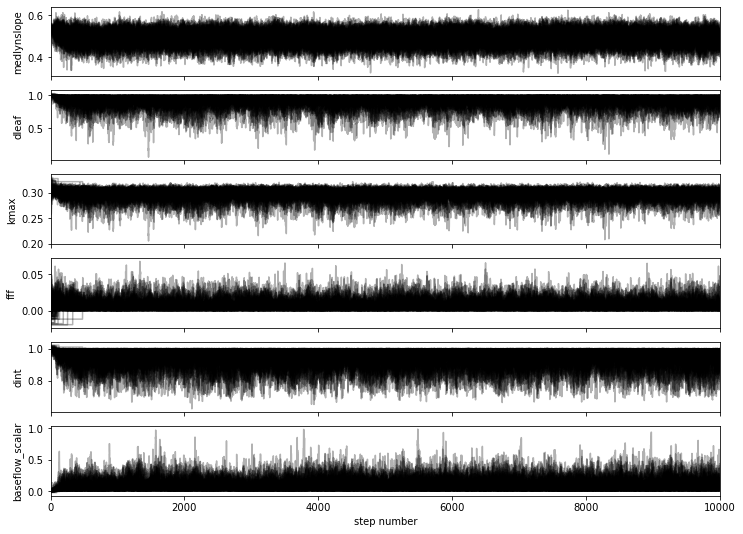

In [110]:
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples_all = sampler.get_chain()
labels = in_vars
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number");
#plt.savefig("MCMC_sampler_chain_1e4epochs_correctobs_initopt_modewgt.pdf")

Plot log probability

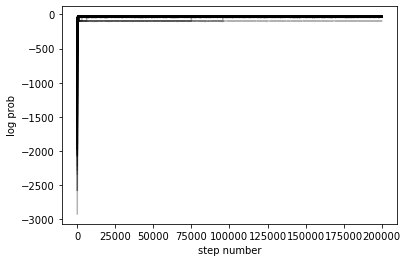

In [91]:
probs_all = sampler.get_log_prob()
#print(probs_all.shape)
plt.plot(probs_all, "k", alpha=0.3) # can't figure out the best way to plot this; too large to exponentiate
plt.xlabel("step number")
plt.ylabel("log prob");

Average log probability for last position of all walkers

In [104]:
print(np.mean(probs_all[epochs-1,:]))

-33.60927940909247


Get estimate of autocorrelation time - helps determine length of chain (number of epochs)

In [105]:
tau = sampler.get_autocorr_time()
print(tau) # do I need a longer chain? emcee will produce generalized estimates/guidance (i.e., run for epochs=50*tau)

[121.58028927 162.30529298 151.99357026 145.39123867 131.99946936
 149.69030532]


Plot autocorrelation using different estimates - first define some functions

In [67]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

# automated windowing following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

Iterate over all dimensions and plot

/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


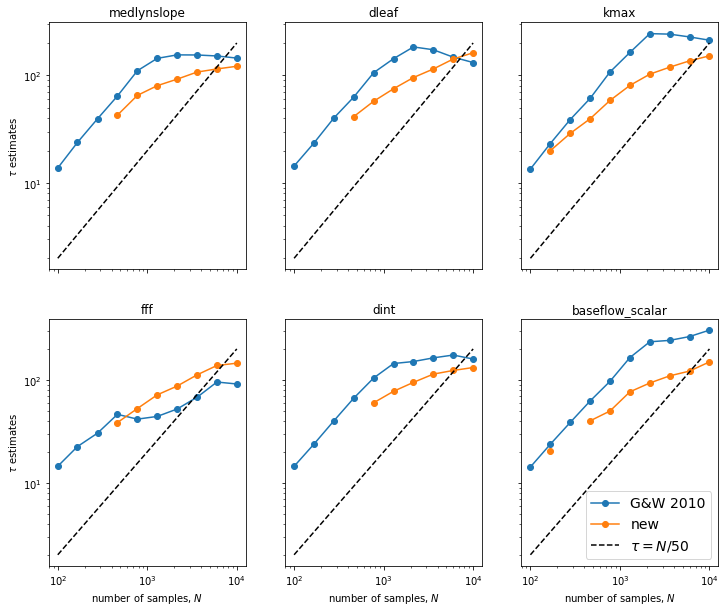

In [113]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(12, 10))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    chain = samples_all[:,:,p].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))

    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # need to run for a long enough chain to get a meaningful figure
    ax = axes[p]
    ax.loglog(N, gw2010, "o-", label="G&W 2010")
    ax.loglog(N, new, "o-", label="new")
    #ylim = plt.gca().get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    #ax.set_ylim(ylim)
    ax.set_title(labels[p])
    
axes[3].set_xlabel("number of samples, $N$")
axes[4].set_xlabel("number of samples, $N$")
axes[5].set_xlabel("number of samples, $N$")
axes[0].set_ylabel(r"$\tau$ estimates")
axes[3].set_ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
#plt.savefig("MCMC_autocorr_1e4epochs_correctobs_initopt_modewgt.pdf")

Plot distributions for final position

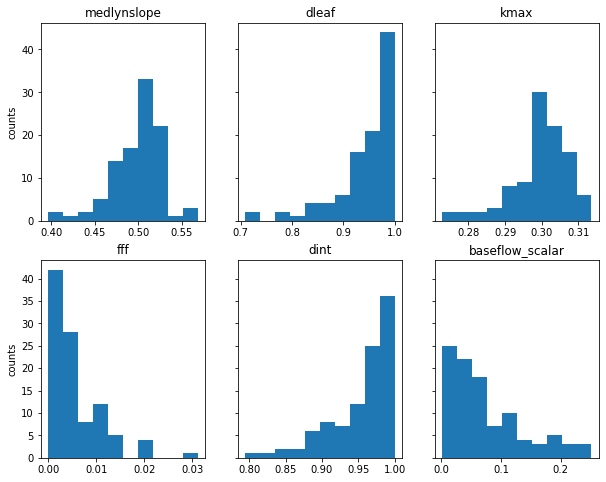

In [109]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey='row', figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    #ax.hist(sampler.chain[:,epochs-1,i], color="k", histtype="step")
    ax.hist(sampler.chain[:,epochs-1,i])
    ax.set_title(labels[i])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

#plt.savefig("MCMC_lastsample_dist_1e4epochs_correctobs_initopt_modewgt.pdf")

Corner plot

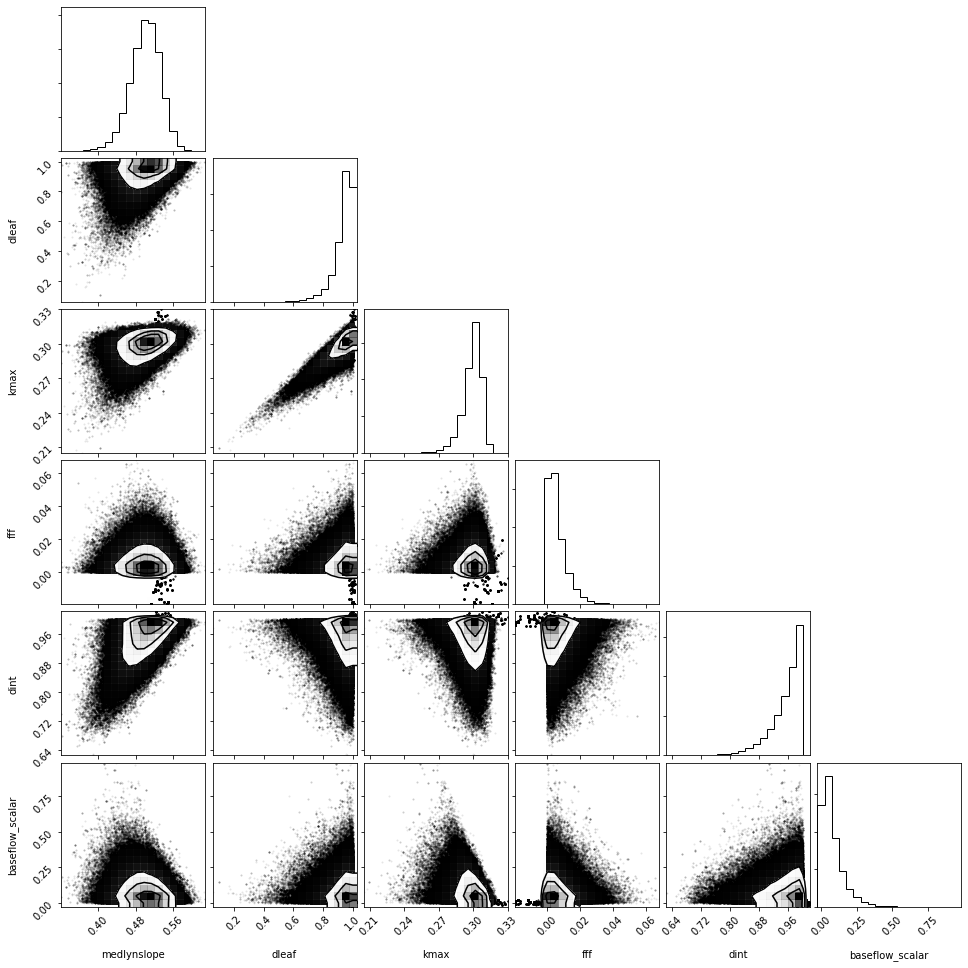

In [112]:
# discard the initial N steps
#flat_samples = sampler.get_chain(discard=10000, flat=True)
# no discard (faster convergence based on initialization)
flat_samples = sampler.get_chain(flat=True)
import corner
fig = corner.corner(flat_samples, labels=in_vars)
#plt.savefig("MCMC_corner_1e4epochs_correctobs_initopt_modewgt.pdf")

In [114]:
# final values for all walkers
last_sample = sampler.chain[:,epochs-1,:]
print(last_sample.shape)
print(np.mean(last_sample, axis=0)) # average (over walkers) last position of each parameter
#np.save("MCMC_posteriors/MCMC_last_sample_1e4epochs_correctobs_initopt_modewgt", last_sample)

(100, 6)
[0.49922338 0.94422237 0.29970828 0.00552892 0.95553073 0.0749857 ]
